# MS COCO圖像偵測 - YOLOv2模型訓練與調整

在[3.0: YOLO物體偵測演算法概念與介紹](https://github.com/erhwenkuo/deep-learning-with-keras-notebooks/blob/master/3.0-yolo-algorithm-introduction.ipynb)的文章裡介紹了YOLO演算法一些重要概念與其它物體偵測演算法的不同之處。

這一篇文章則是要手把手地介紹使用[basic-yolo-keras](https://github.com/erhwenkuo/basic-yolo-keras)來將Darknet預訓練的MS COCO模型進行再訓練與調整來偵測"某些特定圖像類別"。

![cocodataset.org](http://cocodataset.org/images/coco-logo.png)

## 資料集說明

什麼是COCO？

COCO數據集是微軟團隊發起的一個可以用來作圖像識別+分割+標題的圖像數據集，官方網址：http://cocodataset.org 。

官方除了數據以外, 也提供了一組API(一般都稱之為COCO API)來協助加載，解析和可視化COCO中的標註(annotations)。 API支持對象實例(object instance)，對象關鍵點(object keypoints)和圖像標題(image caption)標註(annotation)資訊的提取。

Ps. 由於官方版本的Python COCO tools有一個小bug會導致Python 3在操作時有錯誤產生, 因此在問題尚未被解決之前, 建議使用[[https://github.com/waleedka/coco](https://github.com/waleedka/coco)]的版本

在安裝編譯Python COCO tools的時候, 如果是Windows的平台則需要解決一些Windows上的坑, 詳請見[[Windows 10編譯Pycocotools踩坑記](http://www.jianshu.com/p/de455d653301)]

## basic-yolo-keras 專案說明

[basic-yolo-keras](https://github.com/experiencor/basic-yolo-keras)包含在Keras中使用Tensorflow後端的YOLOv2演算方的實現。它支持訓練YOLOv2網絡與不同的網絡結構，如MobileNet和InceptionV3。

由於原始的專案[experiencor/basic-yolo-keras](https://github.com/experiencor/basic-yolo-keras)主要以英文來說明演算法的實現與再訓練， 對於一些剛入門深度學習的學習者來說，有一些不容易理解與入手的情況。

因此在這個專案的方向在於文件說明的中文化以外，同時也會以一些便於使用與學習的角度進行源碼的調整與修正。

### 需求

- [Keras](https://github.com/fchollet/keras)
- [Tensorflow](https://www.tensorflow.org/)
- [Numpy](http://www.numpy.org/)
- [h5py](http://www.h5py.org/) (For Keras model serialization.)
- [Pillow](https://pillow.readthedocs.io/) (For rendering test results.)
- [Python 3](https://www.python.org/)
- [pydot-ng](https://github.com/pydot/pydot-ng) (Optional for plotting model.)

### 安裝

```bash
git clone https://github.com/erhwenkuo/basic-yolo-keras.git
cd basic-yolo-keras

pip install numpy h5py pillow
pip install tensorflow-gpu  # CPU-only: conda install -c conda-forge tensorflow
pip install keras # Possibly older release: conda install keras
...
```

## 設定COCO圖像資料與標註資料的路徑

在本範例中,我們下載了:
* [2014 Train/Val annotations [241MB]](http://images.cocodataset.org/annotations/annotations_trainval2014.zip)
* [2014 Train images [83K/13GB]](http://images.cocodataset.org/zips/train2014.zip)

並在本Jupyter Notebook的運行的目錄建立一個"data/coco"的子目錄, 然後把上述兩個檔案解壓縮到"coco"的目錄中。最後結果看起來如下:

```
basic-yolo-keras/
├── xxxx.ipynb
├── yolo.weights
├── backend.py
├── preprocessing.py
├── utils.py
├── font/
│   └── FiraMono-Medium.otf
├── yolo.weights
└── data/
    └── coco/
        ├── annotations/                         <--- 標註檔的位置
        │   ├── captions_train2014.json
        │   ├── captions_val2014.json
        │   ├── instances_train2014.json
        │   ├── instances_val2014.json
        │   ├── person_keypoints_train2014.json
        │   └── person_keypoints_val2014.json
        └── train2014/                           <--- 訓練圖像的位置
            ├── COCO_train2014_000000000009.jpg
            ├── COCO_train2014_000000000025.jpg
            ├── ..
            └── COCO_train2014_000000581921.jpg
```

## STEP 1. 載入相關函式庫

In [1]:
# Utilities相關函式庫
import os
import random
from tqdm import tqdm

# 多維向量處理相關函式庫
import numpy as np

# 讓Keras只使用GPU來進行訓練
os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"] = ""

# 圖像處理相關函式庫
import cv2
import imgaug as ia
from imgaug import augmenters as iaa
import colorsys
import matplotlib.pyplot as plt
from PIL import Image, ImageDraw, ImageFont
%matplotlib inline

# 序列/反序列化相關函式庫
import pickle

# 深度學習相關函式庫
from keras.models import Sequential, Model
from keras.layers import Reshape, Activation, Conv2D, Input, MaxPooling2D, BatchNormalization, Flatten, Dense, Lambda
from keras.layers.advanced_activations import LeakyReLU
from keras.callbacks import EarlyStopping, ModelCheckpoint, TensorBoard
from keras.optimizers import SGD, Adam, RMSprop
from keras.layers.merge import concatenate
import keras.backend as K
import tensorflow as tf

# 專案相關函式庫
from preprocessing import parse_annotation, BatchGenerator
from utils import WeightReader, decode_netout, draw_boxes, normalize
from utils import draw_bgr_image_boxes, draw_rgb_image_boxes, draw_pil_image_boxes

Using TensorFlow backend.


### 設定相關設定與參數

In [3]:
# 專案的根目錄路徑
ROOT_DIR = os.getcwd()

# 訓練/驗證用的資料目錄
DATA_PATH = os.path.join(ROOT_DIR, "data")

# 資料集目錄
DATA_SET_PATH = os.path.join(DATA_PATH, "coco")
ANNOTATION_PATH = os.path.join(DATA_SET_PATH, "annotations")
TRAIN_IMGS_PATH = os.path.join(DATA_SET_PATH, "train2014")
VALID_IMGS_PATH = os.path.join(DATA_SET_PATH, "val2014")

dataDir = DATA_SET_PATH
dataType = 'train2014' # 根據下載的coco資料集的年度來設定
annFilename = 'instances_%s.json'%(dataType) # 標註的檔名隨著coco資料集的年度而有不同
annFile = os.path.join(dataDir,"annotations",annFilename) # 要解析的coco標註檔案

### 設定YOLOv2模型的設定與參數

在MS COCO的資料集裡收集了80種的圖像類別的圖像, 但是這次我們將示範如何針對其中某些特定的類別進行微調(fine-tuning)。
這次我選擇了一些跟交通有關類別來進行示範。

In [2]:
#LABELS = ['person', 'bicycle', 'car', 'motorcycle', 'airplane', 'bus', 'train', 'truck', 'boat', 'traffic light', 'fire hydrant', 'stop sign', 'parking meter', 'bench', 'bird', 'cat', 'dog', 'horse', 'sheep', 'cow', 'elephant', 'bear', 'zebra', 'giraffe', 'backpack', 'umbrella', 'handbag', 'tie', 'suitcase', 'frisbee', 'skis', 'snowboard', 'sports ball', 'kite', 'baseball bat', 'baseball glove', 'skateboard', 'surfboard', 'tennis racket', 'bottle', 'wine glass', 'cup', 'fork', 'knife', 'spoon', 'bowl', 'banana', 'apple', 'sandwich', 'orange', 'broccoli', 'carrot', 'hot dog', 'pizza', 'donut', 'cake', 'chair', 'couch', 'potted plant', 'bed', 'dining table', 'toilet', 'tv', 'laptop', 'mouse', 'remote', 'keyboard', 'cell phone', 'microwave', 'oven', 'toaster', 'sink', 'refrigerator', 'book', 'clock', 'vase', 'scissors', 'teddy bear', 'hair drier', 'toothbrush']

LABELS = ['bicycle', 'car', 'motorcycle', 'bus', 'train', 'truck', 'traffic light'] # 選定的圖像類別

IMAGE_H, IMAGE_W = 416, 416 # 模型輸入的圖像長寬
GRID_H,  GRID_W  = 13 , 13
BOX              = 5
CLASS            = len(LABELS)
CLASS_WEIGHTS    = np.ones(CLASS, dtype='float32')
OBJ_THRESHOLD    = 0.3
NMS_THRESHOLD    = 0.3 # NMS非極大值抑制 , 說明(https://chenzomi12.github.io/2016/12/14/YOLO-nms/)
ANCHORS          = [0.57273, 0.677385, 1.87446, 2.06253, 3.33843, 5.47434, 7.88282, 3.52778, 9.77052, 9.16828]

NO_OBJECT_SCALE  = 1.0
OBJECT_SCALE     = 5.0
COORD_SCALE      = 1.0
CLASS_SCALE      = 1.0

BATCH_SIZE       = 16
WARM_UP_BATCHES  = 0
TRUE_BOX_BUFFER  = 50

### Darknet預訓練權重檔與訓練/驗證資料目錄

In [4]:
wt_path = 'yolo.weights'     
train_image_folder = TRAIN_IMGS_PATH
train_annot_folder = ANNOTATION_PATH
valid_image_folder = VALID_IMGS_PATH
valid_annot_folder = ANNOTATION_PATH

## STEP 2. 構建YOLOv2網絡結構模型

In [5]:
# the function to implement the orgnization layer (thanks to github.com/allanzelener/YAD2K)
def space_to_depth_x2(x):
    return tf.space_to_depth(x, block_size=2)

In [6]:
input_image = Input(shape=(IMAGE_H, IMAGE_W, 3))
true_boxes  = Input(shape=(1, 1, 1, TRUE_BOX_BUFFER , 4))

# Layer 1
x = Conv2D(32, (3,3), strides=(1,1), padding='same', name='conv_1', use_bias=False)(input_image)
x = BatchNormalization(name='norm_1')(x)
x = LeakyReLU(alpha=0.1)(x)
x = MaxPooling2D(pool_size=(2, 2))(x)

# Layer 2
x = Conv2D(64, (3,3), strides=(1,1), padding='same', name='conv_2', use_bias=False)(x)
x = BatchNormalization(name='norm_2')(x)
x = LeakyReLU(alpha=0.1)(x)
x = MaxPooling2D(pool_size=(2, 2))(x)

# Layer 3
x = Conv2D(128, (3,3), strides=(1,1), padding='same', name='conv_3', use_bias=False)(x)
x = BatchNormalization(name='norm_3')(x)
x = LeakyReLU(alpha=0.1)(x)

# Layer 4
x = Conv2D(64, (1,1), strides=(1,1), padding='same', name='conv_4', use_bias=False)(x)
x = BatchNormalization(name='norm_4')(x)
x = LeakyReLU(alpha=0.1)(x)

# Layer 5
x = Conv2D(128, (3,3), strides=(1,1), padding='same', name='conv_5', use_bias=False)(x)
x = BatchNormalization(name='norm_5')(x)
x = LeakyReLU(alpha=0.1)(x)
x = MaxPooling2D(pool_size=(2, 2))(x)

# Layer 6
x = Conv2D(256, (3,3), strides=(1,1), padding='same', name='conv_6', use_bias=False)(x)
x = BatchNormalization(name='norm_6')(x)
x = LeakyReLU(alpha=0.1)(x)

# Layer 7
x = Conv2D(128, (1,1), strides=(1,1), padding='same', name='conv_7', use_bias=False)(x)
x = BatchNormalization(name='norm_7')(x)
x = LeakyReLU(alpha=0.1)(x)

# Layer 8
x = Conv2D(256, (3,3), strides=(1,1), padding='same', name='conv_8', use_bias=False)(x)
x = BatchNormalization(name='norm_8')(x)
x = LeakyReLU(alpha=0.1)(x)
x = MaxPooling2D(pool_size=(2, 2))(x)

# Layer 9
x = Conv2D(512, (3,3), strides=(1,1), padding='same', name='conv_9', use_bias=False)(x)
x = BatchNormalization(name='norm_9')(x)
x = LeakyReLU(alpha=0.1)(x)

# Layer 10
x = Conv2D(256, (1,1), strides=(1,1), padding='same', name='conv_10', use_bias=False)(x)
x = BatchNormalization(name='norm_10')(x)
x = LeakyReLU(alpha=0.1)(x)

# Layer 11
x = Conv2D(512, (3,3), strides=(1,1), padding='same', name='conv_11', use_bias=False)(x)
x = BatchNormalization(name='norm_11')(x)
x = LeakyReLU(alpha=0.1)(x)

# Layer 12
x = Conv2D(256, (1,1), strides=(1,1), padding='same', name='conv_12', use_bias=False)(x)
x = BatchNormalization(name='norm_12')(x)
x = LeakyReLU(alpha=0.1)(x)

# Layer 13
x = Conv2D(512, (3,3), strides=(1,1), padding='same', name='conv_13', use_bias=False)(x)
x = BatchNormalization(name='norm_13')(x)
x = LeakyReLU(alpha=0.1)(x)

skip_connection = x

x = MaxPooling2D(pool_size=(2, 2))(x)

# Layer 14
x = Conv2D(1024, (3,3), strides=(1,1), padding='same', name='conv_14', use_bias=False)(x)
x = BatchNormalization(name='norm_14')(x)
x = LeakyReLU(alpha=0.1)(x)

# Layer 15
x = Conv2D(512, (1,1), strides=(1,1), padding='same', name='conv_15', use_bias=False)(x)
x = BatchNormalization(name='norm_15')(x)
x = LeakyReLU(alpha=0.1)(x)

# Layer 16
x = Conv2D(1024, (3,3), strides=(1,1), padding='same', name='conv_16', use_bias=False)(x)
x = BatchNormalization(name='norm_16')(x)
x = LeakyReLU(alpha=0.1)(x)

# Layer 17
x = Conv2D(512, (1,1), strides=(1,1), padding='same', name='conv_17', use_bias=False)(x)
x = BatchNormalization(name='norm_17')(x)
x = LeakyReLU(alpha=0.1)(x)

# Layer 18
x = Conv2D(1024, (3,3), strides=(1,1), padding='same', name='conv_18', use_bias=False)(x)
x = BatchNormalization(name='norm_18')(x)
x = LeakyReLU(alpha=0.1)(x)

# Layer 19
x = Conv2D(1024, (3,3), strides=(1,1), padding='same', name='conv_19', use_bias=False)(x)
x = BatchNormalization(name='norm_19')(x)
x = LeakyReLU(alpha=0.1)(x)

# Layer 20
x = Conv2D(1024, (3,3), strides=(1,1), padding='same', name='conv_20', use_bias=False)(x)
x = BatchNormalization(name='norm_20')(x)
x = LeakyReLU(alpha=0.1)(x)

# Layer 21
skip_connection = Conv2D(64, (1,1), strides=(1,1), padding='same', name='conv_21', use_bias=False)(skip_connection)
skip_connection = BatchNormalization(name='norm_21')(skip_connection)
skip_connection = LeakyReLU(alpha=0.1)(skip_connection)
skip_connection = Lambda(space_to_depth_x2)(skip_connection)

x = concatenate([skip_connection, x])

# Layer 22
x = Conv2D(1024, (3,3), strides=(1,1), padding='same', name='conv_22', use_bias=False)(x)
x = BatchNormalization(name='norm_22')(x)
x = LeakyReLU(alpha=0.1)(x)

# Layer 23
x = Conv2D(BOX * (4 + 1 + CLASS), (1,1), strides=(1,1), padding='same', name='conv_23')(x)
output = Reshape((GRID_H, GRID_W, BOX, 4 + 1 + CLASS))(x)

# small hack to allow true_boxes to be registered when Keras build the model 
# for more information: https://github.com/fchollet/keras/issues/2790
output = Lambda(lambda args: args[0])([output, true_boxes])

model = Model([input_image, true_boxes], output)

In [7]:
model.summary() # 打印模型

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 416, 416, 3)  0                                            
__________________________________________________________________________________________________
conv_1 (Conv2D)                 (None, 416, 416, 32) 864         input_1[0][0]                    
__________________________________________________________________________________________________
norm_1 (BatchNormalization)     (None, 416, 416, 32) 128         conv_1[0][0]                     
__________________________________________________________________________________________________
leaky_re_lu_1 (LeakyReLU)       (None, 416, 416, 32) 0           norm_1[0][0]                     
__________________________________________________________________________________________________
max_poolin

## STEP 3. 載入預訓練的模型權重

**Load the weights originally provided by YOLO**

In [8]:
weight_reader = WeightReader(wt_path) # 初始讀取Darknet預訓練權重檔物件

In [9]:
weight_reader.reset()
nb_conv = 23 # 總共有23層的卷積層

for i in range(1, nb_conv+1):
    conv_layer = model.get_layer('conv_' + str(i))
    
    # 在conv_1~conv_22的卷積組合裡都包含了"conv + norm"二層, 只有conv_23是獨立一層    
    if i < nb_conv: 
        print("handle norm_" + str(i) + " start")        
        norm_layer = model.get_layer('norm_' + str(i)) # 取得BatchNormalization層
        
        size = np.prod(norm_layer.get_weights()[0].shape) # 取得BatchNormalization層的參數量
        print("shape: ", norm_layer.get_weights()[0].shape)
        
        beta  = weight_reader.read_bytes(size)
        gamma = weight_reader.read_bytes(size)
        mean  = weight_reader.read_bytes(size)
        var   = weight_reader.read_bytes(size)
        weights = norm_layer.set_weights([gamma, beta, mean, var])
        print("handle norm_" + str(i) + " completed")
        
    if len(conv_layer.get_weights()) > 1:
        print("handle conv_" + str(i) + " start")  
        print("len:",len(conv_layer.get_weights()))
        bias   = weight_reader.read_bytes(np.prod(conv_layer.get_weights()[1].shape))
        kernel = weight_reader.read_bytes(np.prod(conv_layer.get_weights()[0].shape))
        kernel = kernel.reshape(list(reversed(conv_layer.get_weights()[0].shape)))
        kernel = kernel.transpose([2,3,1,0])
        conv_layer.set_weights([kernel, bias])
        print("handle conv_" + str(i) + " completed")
    else:
        print("handle conv_" + str(i) + " start")        
        kernel = weight_reader.read_bytes(np.prod(conv_layer.get_weights()[0].shape))
        kernel = kernel.reshape(list(reversed(conv_layer.get_weights()[0].shape)))
        kernel = kernel.transpose([2,3,1,0])
        conv_layer.set_weights([kernel])
        print("handle conv_" + str(i) + " completed")

handle norm_1 start
shape:  (32,)
handle norm_1 completed
handle conv_1 start
handle conv_1 completed
handle norm_2 start
shape:  (64,)
handle norm_2 completed
handle conv_2 start
handle conv_2 completed
handle norm_3 start
shape:  (128,)
handle norm_3 completed
handle conv_3 start
handle conv_3 completed
handle norm_4 start
shape:  (64,)
handle norm_4 completed
handle conv_4 start
handle conv_4 completed
handle norm_5 start
shape:  (128,)
handle norm_5 completed
handle conv_5 start
handle conv_5 completed
handle norm_6 start
shape:  (256,)
handle norm_6 completed
handle conv_6 start
handle conv_6 completed
handle norm_7 start
shape:  (128,)
handle norm_7 completed
handle conv_7 start
handle conv_7 completed
handle norm_8 start
shape:  (256,)
handle norm_8 completed
handle conv_8 start
handle conv_8 completed
handle norm_9 start
shape:  (512,)
handle norm_9 completed
handle conv_9 start
handle conv_9 completed
handle norm_10 start
shape:  (256,)
handle norm_10 completed
handle conv_10 

## STEP 4. 設定要微調(fine-tune)的模型層級權重

**Randomize weights of the last layer**

由於在YOLOv2的模型中, 最後一層卷積層決定了最後的輸出, 讓我們重新來調整與訓練這一層的卷積層來讓預訓練的模型可以讓我們進行所需要的微調。
詳細的概念與說明,見 [1.5: 使用預先訓練的卷積網絡模型](https://github.com/erhwenkuo/deep-learning-with-keras-notebooks/blob/master/1.5-use-pretrained-model-2.ipynb)。

In [10]:
layer   = model.layers[-4] # 找出最後一層的卷積層
weights = layer.get_weights()

new_kernel = np.random.normal(size=weights[0].shape)/(GRID_H*GRID_W)
new_bias   = np.random.normal(size=weights[1].shape)/(GRID_H*GRID_W)

layer.set_weights([new_kernel, new_bias]) # 重初始化權重

## STEP 5. 模型訓練

**YOLOv2訓練用的損失函數:**

$$\begin{multline}
\lambda_\textbf{coord}
\sum_{i = 0}^{S^2}
    \sum_{j = 0}^{B}
     L_{ij}^{\text{obj}}
            \left[
            \left(
                x_i - \hat{x}_i
            \right)^2 +
            \left(
                y_i - \hat{y}_i
            \right)^2
            \right]
\\
+ \lambda_\textbf{coord} 
\sum_{i = 0}^{S^2}
    \sum_{j = 0}^{B}
         L_{ij}^{\text{obj}}
         \left[
        \left(
            \sqrt{w_i} - \sqrt{\hat{w}_i}
        \right)^2 +
        \left(
            \sqrt{h_i} - \sqrt{\hat{h}_i}
        \right)^2
        \right]
\\
+ \sum_{i = 0}^{S^2}
    \sum_{j = 0}^{B}
        L_{ij}^{\text{obj}}
        \left(
            C_i - \hat{C}_i
        \right)^2
\\
+ \lambda_\textrm{noobj}
\sum_{i = 0}^{S^2}
    \sum_{j = 0}^{B}
    L_{ij}^{\text{noobj}}
        \left(
            C_i - \hat{C}_i
        \right)^2
\\
+ \sum_{i = 0}^{S^2}
L_i^{\text{obj}}
    \sum_{c \in \textrm{classes}}
        \left(
            p_i(c) - \hat{p}_i(c)
        \right)^2
\end{multline}$$

In [11]:
def custom_loss(y_true, y_pred):
    mask_shape = tf.shape(y_true)[:4]
    
    cell_x = tf.to_float(tf.reshape(tf.tile(tf.range(GRID_W), [GRID_H]), (1, GRID_H, GRID_W, 1, 1)))
    cell_y = tf.transpose(cell_x, (0,2,1,3,4))

    cell_grid = tf.tile(tf.concat([cell_x,cell_y], -1), [BATCH_SIZE, 1, 1, 5, 1])
    
    coord_mask = tf.zeros(mask_shape)
    conf_mask  = tf.zeros(mask_shape)
    class_mask = tf.zeros(mask_shape)
    
    seen = tf.Variable(0.)
    total_recall = tf.Variable(0.)
    
    """
    Adjust prediction
    """
    ### adjust x and y      
    pred_box_xy = tf.sigmoid(y_pred[..., :2]) + cell_grid
    
    ### adjust w and h
    pred_box_wh = tf.exp(y_pred[..., 2:4]) * np.reshape(ANCHORS, [1,1,1,BOX,2])
    
    ### adjust confidence
    pred_box_conf = tf.sigmoid(y_pred[..., 4])
    
    ### adjust class probabilities
    pred_box_class = y_pred[..., 5:]
    
    """
    Adjust ground truth
    """
    ### adjust x and y
    true_box_xy = y_true[..., 0:2] # relative position to the containing cell
    
    ### adjust w and h
    true_box_wh = y_true[..., 2:4] # number of cells accross, horizontally and vertically
    
    ### adjust confidence
    true_wh_half = true_box_wh / 2.
    true_mins    = true_box_xy - true_wh_half
    true_maxes   = true_box_xy + true_wh_half
    
    pred_wh_half = pred_box_wh / 2.
    pred_mins    = pred_box_xy - pred_wh_half
    pred_maxes   = pred_box_xy + pred_wh_half       
    
    intersect_mins  = tf.maximum(pred_mins,  true_mins)
    intersect_maxes = tf.minimum(pred_maxes, true_maxes)
    intersect_wh    = tf.maximum(intersect_maxes - intersect_mins, 0.)
    intersect_areas = intersect_wh[..., 0] * intersect_wh[..., 1]
    
    true_areas = true_box_wh[..., 0] * true_box_wh[..., 1]
    pred_areas = pred_box_wh[..., 0] * pred_box_wh[..., 1]

    union_areas = pred_areas + true_areas - intersect_areas
    iou_scores  = tf.truediv(intersect_areas, union_areas)
    
    true_box_conf = iou_scores * y_true[..., 4]
    
    ### adjust class probabilities
    true_box_class = tf.argmax(y_true[..., 5:], -1)
    
    """
    Determine the masks
    """
    ### coordinate mask: simply the position of the ground truth boxes (the predictors)
    coord_mask = tf.expand_dims(y_true[..., 4], axis=-1) * COORD_SCALE
    
    ### confidence mask: penelize predictors + penalize boxes with low IOU
    # penalize the confidence of the boxes, which have IOU with some ground truth box < 0.6
    true_xy = true_boxes[..., 0:2]
    true_wh = true_boxes[..., 2:4]
    
    true_wh_half = true_wh / 2.
    true_mins    = true_xy - true_wh_half
    true_maxes   = true_xy + true_wh_half
    
    pred_xy = tf.expand_dims(pred_box_xy, 4)
    pred_wh = tf.expand_dims(pred_box_wh, 4)
    
    pred_wh_half = pred_wh / 2.
    pred_mins    = pred_xy - pred_wh_half
    pred_maxes   = pred_xy + pred_wh_half    
    
    intersect_mins  = tf.maximum(pred_mins,  true_mins)
    intersect_maxes = tf.minimum(pred_maxes, true_maxes)
    intersect_wh    = tf.maximum(intersect_maxes - intersect_mins, 0.)
    intersect_areas = intersect_wh[..., 0] * intersect_wh[..., 1]
    
    true_areas = true_wh[..., 0] * true_wh[..., 1]
    pred_areas = pred_wh[..., 0] * pred_wh[..., 1]

    union_areas = pred_areas + true_areas - intersect_areas
    iou_scores  = tf.truediv(intersect_areas, union_areas)

    best_ious = tf.reduce_max(iou_scores, axis=4)
    conf_mask = conf_mask + tf.to_float(best_ious < 0.6) * (1 - y_true[..., 4]) * NO_OBJECT_SCALE
    
    # penalize the confidence of the boxes, which are reponsible for corresponding ground truth box
    conf_mask = conf_mask + y_true[..., 4] * OBJECT_SCALE
    
    ### class mask: simply the position of the ground truth boxes (the predictors)
    class_mask = y_true[..., 4] * tf.gather(CLASS_WEIGHTS, true_box_class) * CLASS_SCALE       
    
    """
    Warm-up training
    """
    no_boxes_mask = tf.to_float(coord_mask < COORD_SCALE/2.)
    seen = tf.assign_add(seen, 1.)
    
    true_box_xy, true_box_wh, coord_mask = tf.cond(tf.less(seen, WARM_UP_BATCHES), 
                          lambda: [true_box_xy + (0.5 + cell_grid) * no_boxes_mask, 
                                   true_box_wh + tf.ones_like(true_box_wh) * np.reshape(ANCHORS, [1,1,1,BOX,2]) * no_boxes_mask, 
                                   tf.ones_like(coord_mask)],
                          lambda: [true_box_xy, 
                                   true_box_wh,
                                   coord_mask])
    
    """
    Finalize the loss
    """
    nb_coord_box = tf.reduce_sum(tf.to_float(coord_mask > 0.0))
    nb_conf_box  = tf.reduce_sum(tf.to_float(conf_mask  > 0.0))
    nb_class_box = tf.reduce_sum(tf.to_float(class_mask > 0.0))
    
    loss_xy    = tf.reduce_sum(tf.square(true_box_xy-pred_box_xy)     * coord_mask) / (nb_coord_box + 1e-6) / 2.
    loss_wh    = tf.reduce_sum(tf.square(true_box_wh-pred_box_wh)     * coord_mask) / (nb_coord_box + 1e-6) / 2.
    loss_conf  = tf.reduce_sum(tf.square(true_box_conf-pred_box_conf) * conf_mask)  / (nb_conf_box  + 1e-6) / 2.
    loss_class = tf.nn.sparse_softmax_cross_entropy_with_logits(labels=true_box_class, logits=pred_box_class)
    loss_class = tf.reduce_sum(loss_class * class_mask) / (nb_class_box + 1e-6)
    
    loss = loss_xy + loss_wh + loss_conf + loss_class
    
    nb_true_box = tf.reduce_sum(y_true[..., 4])
    nb_pred_box = tf.reduce_sum(tf.to_float(true_box_conf > 0.5) * tf.to_float(pred_box_conf > 0.3))

    """
    Debugging code
    """    
    current_recall = nb_pred_box/(nb_true_box + 1e-6)
    total_recall = tf.assign_add(total_recall, current_recall) 

    loss = tf.Print(loss, [tf.zeros((1))], message='Dummy Line \t', summarize=1000)
    loss = tf.Print(loss, [loss_xy], message='Loss XY \t', summarize=1000)
    loss = tf.Print(loss, [loss_wh], message='Loss WH \t', summarize=1000)
    loss = tf.Print(loss, [loss_conf], message='Loss Conf \t', summarize=1000)
    loss = tf.Print(loss, [loss_class], message='Loss Class \t', summarize=1000)
    loss = tf.Print(loss, [loss], message='Total Loss \t', summarize=1000)
    loss = tf.Print(loss, [current_recall], message='Current Recall \t', summarize=1000)
    loss = tf.Print(loss, [total_recall/seen], message='Average Recall \t', summarize=1000)
    
    return loss

**用來產生Keras訓練模型的BatchGenerator的設定:**

In [12]:
generator_config = {
    'IMAGE_H'         : IMAGE_H, # YOLOv2網絡輸入的image_h
    'IMAGE_W'         : IMAGE_W, # YOLOv2網絡輸入的image_w
    'GRID_H'          : GRID_H,  # 直向網格的拆分數量
    'GRID_W'          : GRID_W,  # 橫向網格的拆分數量
    'BOX'             : BOX,     # 每個單一網格要預測的邊界框數量
    'LABELS'          : LABELS,  # 要預測的圖像種類列表
    'CLASS'           : len(LABELS), # 要預測的圖像種類數
    'ANCHORS'         : ANCHORS, # 每個單一網格要預測的邊界框時用的錨點
    'BATCH_SIZE'      : BATCH_SIZE, # 訓練時的批量數
    'TRUE_BOX_BUFFER' : 50, # 一個訓練圖像最大數量的邊界框數
}

### 解析圖像標註檔

由於MS COCO資料集的標註檔並不是採用PASCAL VOC格式而是自行定義的格式, 而且MS COCO有設計存取圖像與圖像標註的API。
因此我們要對標註檔的解析進行客製化的處理。

In [13]:
import os
from pycocotools.coco import COCO

def parse_coco_annotation(ann_dir, img_dir, data_type='train2014', labels=[]):    
    # 初始要回傳的兩個物件    
    all_imgs = []
    seen_labels = {}
    
    annFilename = 'instances_%s.json'%(data_type) # 標註的檔名隨著coco資料集的年度而有不同
    annFile = os.path.join(ann_dir, annFilename) # 要解析的coco標註檔案
    
    print("Annotation: ", annFile)
    
    # 初始化 COCO api物件的實例並載入對象實例(object instance)標註
    coco=COCO(annFile)
    
    # 取得所有類別物件列表
    cats = coco.loadCats(coco.getCatIds())
    
    # 建立兩個索引
    catId_to_catName = {}
    catName_to_catId = {}
    
    for cat in cats:
        catId = cat['id']
        catName = cat['name']
        catId_to_catName[catId]=catName
        catName_to_catId[catName]=catId
    
    catIds = []
    for label in labels:
        assert label in catName_to_catId, '{} not exist in Coco image categories!'.format(label)
        catIds.append(catName_to_catId[label])
    
    print("catIds:", catIds)
    if(len(catIds)==0): # 如果沒有符合的類別
        return all_imgs, seen_labels # 離開
    
    #取得這些類別的圖像ids
    imgIds = set()
    for catId in catIds:
        for imgId in coco.catToImgs[catId]:
            imgIds.add(imgId)
    
    #imgIds = coco.getImgIds(catIds=catIds) # 取得這些類別的圖像ids  
    
    imgs = coco.loadImgs(ids=list(imgIds))
    
    # 迭代所有符合條件的圖像
    for coco_img in imgs:
        img = {'object':[]}
        img['filename'] = os.path.join(img_dir, coco_img['file_name'])
        img['width'] = coco_img['width']
        img['height'] = coco_img['height']
        # 處理bbox
        annIds = coco.getAnnIds(imgIds=coco_img['id'], catIds=catIds)
        anns = coco.loadAnns(ids=annIds)
        # 迭代圖像裡的每一個標註
        for ann in anns:
            obj = {}
            obj['name'] = coco.loadCats(ann['category_id'])[0]['name']
            
            if obj['name'] in seen_labels:
                seen_labels[obj['name']] += 1
            else:
                seen_labels[obj['name']] = 1
                
            # "bbox" : [x,y,width,height]
            obj['xmin'] = ann['bbox'][0]               # x
            obj['ymin'] = ann['bbox'][1]               # y
            obj['xmax'] = obj['xmin'] + ann['bbox'][2] # x + w
            obj['ymax'] = obj['ymin'] + ann['bbox'][3] # y + h
            img['object'].append(obj) # 把標註物件加入的列表
            
        all_imgs.append(img) # 把圖像物件加入列
        
    return all_imgs, seen_labels

In [14]:
# 進行圖像標註檔的解析
train_imgs, seen_train_labels = parse_coco_annotation(train_annot_folder, train_image_folder, data_type='train2014', 
                                                      labels=LABELS)

# 建立一個訓練用的資料產生器
train_batch = BatchGenerator(train_imgs, generator_config, norm=normalize)

# 進行圖像標註檔的解析
valid_imgs, seen_valid_labels = parse_coco_annotation(valid_annot_folder, valid_image_folder, data_type='val2014', 
                                                      labels=LABELS)

# 建立一個驗證用的資料產生器
valid_batch = BatchGenerator(valid_imgs, generator_config, norm=normalize, jitter=False)

Annotation:  D:\pythonworks\01_erhwen\basic-yolo-keras\data\coco\annotations\instances_train2014.json
loading annotations into memory...
Done (t=11.56s)
creating index...
index created!
catIds: [2, 3, 4, 6, 7, 8, 10]
Annotation:  D:\pythonworks\01_erhwen\basic-yolo-keras\data\coco\annotations\instances_val2014.json
loading annotations into memory...
Done (t=5.53s)
creating index...
index created!
catIds: [2, 3, 4, 6, 7, 8, 10]


### 設置一些回調函式並開始訓練

In [17]:
# 如果超過15次的循環在loss的收歛上沒有改善就停止訓練 
early_stop = EarlyStopping(monitor='val_loss', 
                           min_delta=0.001, 
                           patience=15, 
                           mode='min', 
                           verbose=2)

# 每次的訓練循都去比較模型的loss是否有改善, 有就把模型的權重儲存下來
checkpoint = ModelCheckpoint('weights_coco_ontheroad.h5', 
                             monitor='val_loss', 
                             verbose=2, 
                             save_best_only=True, 
                             mode='min', 
                             period=1)

### 開始訓練

由於MS COCO資料集的圖像資料與標註資料比較多, 每次的訓練循環都會花比較快的時間。在Nvidia 1080Ti的單一顯卡的訓練, 每次的循環都約莫會花11分鐘左右。

In [ ]:
optimizer = Adam(lr=0.5e-4, beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=0.0)
#optimizer = SGD(lr=1e-4, decay=0.0005, momentum=0.9)
#optimizer = RMSprop(lr=1e-4, rho=0.9, epsilon=1e-08, decay=0.0)

model.compile(loss=custom_loss, optimizer=optimizer)

model.fit_generator(generator        = train_batch, 
                    steps_per_epoch  = len(train_batch), 
                    epochs           = 100, # 100次的訓練循環 
                    verbose          = 2,
                    validation_data  = valid_batch,
                    validation_steps = len(valid_batch),
                    callbacks        = [early_stop, checkpoint], 
                    max_queue_size   = 3)

Epoch 1/100
Epoch 00001: val_loss improved from inf to 0.77155, saving model to weights_coco_ontheroad.h5
 - 815s - loss: 1.1541 - val_loss: 0.7716
Epoch 2/100
Epoch 00002: val_loss improved from 0.77155 to 0.67801, saving model to weights_coco_ontheroad.h5
 - 630s - loss: 0.7799 - val_loss: 0.6780
Epoch 3/100
Epoch 00003: val_loss improved from 0.67801 to 0.65556, saving model to weights_coco_ontheroad.h5
 - 633s - loss: 0.6904 - val_loss: 0.6556
Epoch 4/100
Epoch 00004: val_loss improved from 0.65556 to 0.62855, saving model to weights_coco_ontheroad.h5
 - 632s - loss: 0.6342 - val_loss: 0.6286
Epoch 5/100
Epoch 00005: val_loss improved from 0.62855 to 0.61254, saving model to weights_coco_ontheroad.h5
 - 633s - loss: 0.5939 - val_loss: 0.6125
Epoch 6/100
Epoch 00006: val_loss did not improve
 - 630s - loss: 0.5544 - val_loss: 0.6313
Epoch 7/100
Epoch 00007: val_loss did not improve
 - 634s - loss: 0.5263 - val_loss: 0.6311
Epoch 8/100
Epoch 00008: val_loss did not improve
 - 629s - 

## STEP 6. 圖像的物體偵測

In [19]:
# 載入訓練好的模型權重
model.load_weights("weights_coco_ontheroad.h5")

# 產生一個Dummy的標籤輸入

# 在訓練階段放的是真實的邊界框與圖像類別訊息
# 但在預測階段還是需要有一個Dummy的輸入, 因為定義在網絡的結構中有兩個輸入： 
#   1.圖像的輸人 
#   2.圖像邊界框/錨點/信心分數的輸入
dummy_array = np.zeros((1,1,1,1,TRUE_BOX_BUFFER,4))

In [20]:
# 驗證用的圖像目錄，預設為"images/"
TEST_PATH = os.path.join(ROOT_DIR, "images")

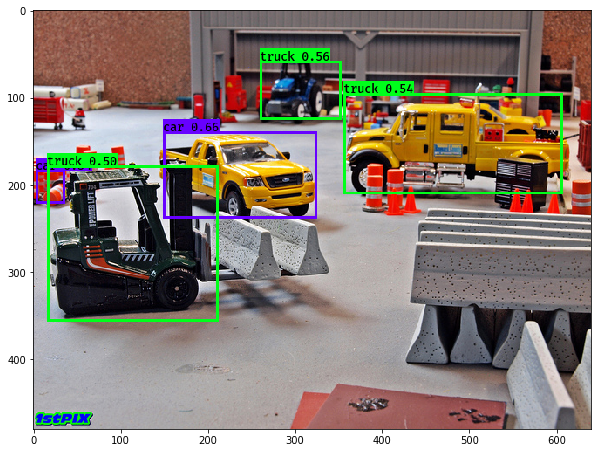

In [33]:
from utils import draw_bgr_image_boxes, draw_rgb_image_boxes

# 選一張圖像並使用OpenCV讀入圖像
image = cv2.imread(train_imgs[np.random.randint(len(train_imgs))]['filename'])

plt.figure(figsize=(10,10))

# 進行圖像輸入的前處理
input_image = cv2.resize(image, (416, 416)) # 修改輸入圖像大小來符合模型的要求
input_image = input_image / 255. # 進行圖像歸一處理
input_image = np.expand_dims(input_image, 0) # 增加 batch dimension

# 進行圖像偵測
netout = model.predict([input_image, dummy_array])

# 解析網絡的輸出來取得最後偵測出來的邊界框(bounding boxes)列表
boxes = decode_netout(netout[0], 
                      obj_threshold=OBJ_THRESHOLD,
                      nms_threshold=NMS_THRESHOLD,
                      anchors=ANCHORS, 
                      nb_class=CLASS)

# "draw_bgr_image_boxes"
# 一個簡單把邊界框與預測結果打印到原始圖像(BGR)上的工具函式
# 參數: image 是image的numpy ndarray [h, w, channels(BGR)]
#       boxes 是偵測的結果
#       labels 是模型訓練的圖像類別列表
# 回傳： image 是image的numpy ndarray [h, w, channels(RGB)]
image = draw_bgr_image_boxes(image, boxes, labels=LABELS)

# 把最後的結果秀出來
plt.imshow(image)
plt.show()

## STEP 6. 影像的物體偵測

In [35]:
# 載入訓練好的模型權重
model.load_weights("weights_coco_ontheroad.h5")

# 產生一個Dummy的標籤輸入

# 在訓練階段放的是真實的邊界框與圖像類別訊息
# 但在預測階段還是需要有一個Dummy的輸入, 因為定義在網絡的結構中有兩個輸入： 
#   1.圖像的輸人 
#   2.圖像邊界框/錨點/信心分數的輸入
dummy_array = np.zeros((1,1,1,1,TRUE_BOX_BUFFER,4))

In [37]:
# 資料集目錄
VIDEO_DATA_PATH = os.path.join(DATA_SET_PATH, "video")

# 選擇要進行浣熊影像偵測的影像檔
# 在這個測試我從YOUTUBE下載了: https://www.youtube.com/watch?v=IO5vLENETg0
video_inp =  os.path.join(VIDEO_DATA_PATH, "taipei_traffic.mp4")

# 偵測結果的輸出影像檔
video_out =  os.path.join(VIDEO_DATA_PATH, "taipei_traffic_yolov2.mp4")

# 透過OpenCv擷取影像
video_reader = cv2.VideoCapture(video_inp)

# 取得影像的基本資訊
nb_frames = int(video_reader.get(cv2.CAP_PROP_FRAME_COUNT)) # 總共有多少frames
frame_h = int(video_reader.get(cv2.CAP_PROP_FRAME_HEIGHT))  # 每個frame的高
frame_w = int(video_reader.get(cv2.CAP_PROP_FRAME_WIDTH))   # 每個frame的寬

# 設定影像的輸出
video_writer = cv2.VideoWriter(video_out,
                               cv2.VideoWriter_fourcc(*'XVID'), 
                               50.0, 
                               (frame_w, frame_h))

# 迭代每一個frame來進行圖像偵測
for i in tqdm(range(nb_frames)):
    ret, image = video_reader.read() # 讀取一個frame
    
    input_image = cv2.resize(image, (416, 416)) # 修改輸入圖像大小來符合模型的要求
    input_image = input_image / 255. # 進行圖像歸一處理
    input_image = np.expand_dims(input_image, 0) # 增加 batch dimension

    # 進行圖像偵測
    netout = model.predict([input_image, dummy_array])

    # 解析網絡的輸出來取得最後偵測出來的邊界框(bounding boxes)列表
    boxes = decode_netout(netout[0], 
                          obj_threshold=OBJ_THRESHOLD,
                          nms_threshold=NMS_THRESHOLD,
                          anchors=ANCHORS, 
                          nb_class=CLASS)
    
    # "draw_bgr_image_boxes"
    # 一個簡單把邊界框與預測結果打印到原始圖像(BGR)上的工具函式
    # 參數: image 是image的numpy ndarray [h, w, channels(BGR)]
    #       boxes 是偵測的結果
    #       labels 是模型訓練的圖像類別列表
    # 回傳： image 是image的numpy ndarray [h, w, channels(RGB)]
    image = draw_bgr_image_boxes(image, boxes, labels=LABELS)

    # 透過OpenCV把影像輸出出來
    video_writer.write(np.uint8(image[:,:,::-1])) # 轉換 RGB -> BGR來讓Open CV寫Video
    
video_reader.release() # 釋放資源
video_writer.release() # 釋放資源

100%|██████████████████████████████████████████████████████████████████████████████| 2313/2313 [01:59<00:00, 19.31it/s]


參考:
* [YOLO官網](https://pjreddie.com/darknet/yolo/)
* [llSourcell/YOLO_Object_Detection](https://github.com/llSourcell/YOLO_Object_Detection)
* [experiencor/basic-yolo-keras](https://github.com/experiencor/basic-yolo-keras)
* [COCO數據集](http://cocodataset.org)